# Задача поиска штрихкодов

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import csv
import cv2

from unet import Unet
from metrics import DiceLoss, CombinationLoss
from training import train, validate

from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from pytorch_lightning import LightningModule, Trainer

In [2]:
DATASET_PATH = Path().absolute() / 'CourseOCRTask3'/ 'Train' / 'markup.csv'
TRAIN_PATH = Path().absolute() / 'CourseOCRTask3' / 'Train' / 'Images'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
markup = []
with open(DATASET_PATH, 'r', encoding='utf-16') as file:
    reader = csv.reader(file)
    for row in reader:
        path_to_img = TRAIN_PATH.joinpath(row[0])
        row[0] = path_to_img 
        markup.append(row)

In [4]:
def get_img(path):
    return cv2.imread(str(path), cv2.IMREAD_ANYCOLOR)

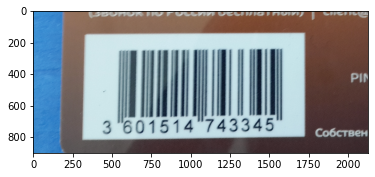

In [7]:
plt.imshow(get_img(markup[0][0]))

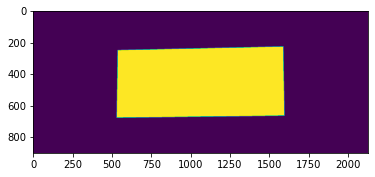

In [8]:
image_shape = torch.tensor(get_img(markup[0][0])).shape[:-1]
mask = np.zeros(image_shape)
dt = markup[0]
corner_coordinates = np.array([[dt[2], dt[3]], [dt[4], dt[5]], [dt[6], dt[7]], [dt[8], dt[9]]]).astype(int)
plt.imshow(cv2.fillConvexPoly(mask, np.array(corner_coordinates), 1));

In [ ]:
class BarcodeDataset(Dataset):
    def __init__(self, markup):
        self.markup = markup

    def __len__(self):
        return len(self.markup)

    def __getitem__(self, idx):
        dt = self.markup[idx]
        img = torch.tensor(np.array(get_img(dt[0])))
        img_shape = img.shape[:-1]

        corner_coordinates = np.array([[dt[2], dt[3]], [dt[4], dt[5]], [dt[6], dt[7]], [dt[8], dt[9]]]).astype(int)
        mask = np.zeros(img_shape)
        mask = torch.FloatTensor(cv2.fillConvexPoly(mask, corner_coordinates,1))
        
        img = cv2.resize(np.array(img), (256, 256))
        mask = cv2.resize(np.array(mask), (256, 256))
        mask = mask[None,:,:]
        return torch.from_numpy(img).permute(2, 0, 1), torch.from_numpy(mask)

Датасет очень большой, воспользуемся только частью:

In [6]:
data = markup[:800]

In [7]:
data = BarcodeDataset(data)
train_dataset, val_dataset = train_test_split(data, test_size=0.1)

In [8]:
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 720
Validation dataset size: 80


In [9]:
batch_size = 10

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Модель
Я воспользовалась моделью семнатической сегментации Unet с backbone resnet50.

In [10]:
model = Unet(classes=1)

criterion = CombinationLoss()

optimizer = torch.optim.AdamW(model.parameters())

In [15]:
model

Unet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Обучение

train_losses = []
val_losses = []

num_epochs = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch, num_epochs, device)
    val_loss = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

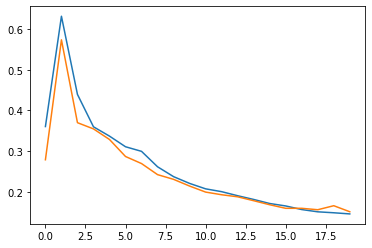

In [24]:
plt.plot(range(len(train_losses)), train_losses, val_losses)

## Оценим предсказания

In [17]:
TEST_PATH = Path().absolute() / 'CourseOCRTask3' / 'Test' / 'Images'
assert TEST_PATH.exists(), TEST_PATH.absolute()

In [18]:
def find_corners(mask):
    binary_mask = (torch.sigmoid(mask) > 0.5).cpu().numpy().astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    
    corners_indices = np.array([np.argmin(x + y), np.argmin(-x + y), np.argmax(x + y), np.argmax(-x + y)])
    corners = np.array([x[corners_indices], y[corners_indices]]).T
    
    return corners.astype(float)

In [90]:
all_test_paths = list(TEST_PATH.glob('*'))

In [92]:
test_paths = []

for path in all_test_paths:
    path = str(path)
    if path.endswith(".png"):
        test_paths.append(path)

In [93]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        img = np.array(get_img(path))
        img_shape = img.shape[:-1]
        img = cv2.resize(img, (256, 256))
            
        return torch.tensor(img).permute(2, 0, 1), img_shape

In [94]:
test_dataset = TestDataset(test_paths)

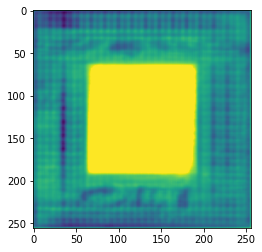

In [95]:
img, sz = test_dataset[0]
img = img.to(device, dtype=torch.float)
img = img[None, :, :, :]
mask = model.forward(img)
plt.imshow(np.squeeze(mask.detach().numpy()))

Посмотрим на прмиеры предсказаний:

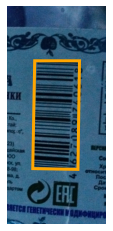

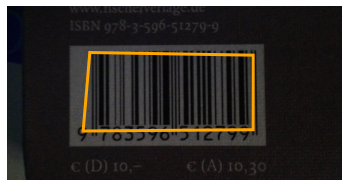

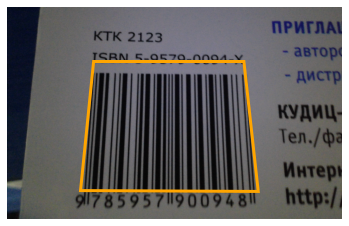

In [96]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

with torch.no_grad():
    for i in range(3):
        model.eval()
        img, sz = test_dataset[i]
        img = img[None, :, :, :]
        img = img.to(device, dtype=torch.float)
        mask = model.forward(img)
        
        mask = transforms.Resize(sz, interpolation=InterpolationMode.NEAREST)(mask)
        corners = find_corners(mask.squeeze())
        
        fig, ax = plt.subplots()
        patch = plt.Polygon(corners, facecolor='none', edgecolor='orange', lw=3)
        ax.add_patch(patch)
        images = get_img(test_paths[i])
        plt.imshow(images)
        plt.axis('off')
        plt.show()

In [97]:
image_names = []

for path in test_paths:
    image_names.append(path.split('/')[-1])

In [98]:
corners = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        model.eval()
        img, sz = test_dataset[i]
        img = img[None, :, :, :]
        img = img.to(device, dtype=torch.float)
        mask = model.forward(img)
        
        mask = transforms.Resize(sz, interpolation=InterpolationMode.NEAREST)(mask)
        corners.append(find_corners(mask.squeeze()))

In [103]:
with open('answer.csv', mode='w', newline='', encoding='utf-16') as file:
    
    for i in range(len(corners)):
        file.write(image_names[i] + ',-,' + ','.join([str(int(j)) for j in np.resize(corners[i], 8)]) + ',-\n')

In [106]:
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/home/nikita/task3/answer.csv) against markup(/home/nikita/task3/markup.csv)
recognition_accuracy=0.0
detection_result=0.98
score=0.98
